IM2 b11705022 李訓佑

Load data and normalize data

In [37]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


# Q1
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。



Write a OLS model, we use `sklearn.linear_model.LinearRegression()`, then put the x_train and y_train in it to train.

Since we don't need to use validation set, I didn't put subtrain as training set.

Since there's no RMSE, we use MSE and use `sqrt()` on `MSE`

In [19]:
# train model, with no regularization
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)

# predict
Y_pred = ols.predict(X_test)

# calculate RMSE
rmse = sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE = ", rmse)

# print first five features
print("First five features: ", ols.coef_[0:5])

RMSE =  9.510160684544397
First five features:  [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


We can see the RMSE is 9.51, and the first 5 features are [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]

# Q2
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。 接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。 然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。 所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

### Building model:

1. Build the MLP with 5 Layers, 90--l1>>H--l2>>H--l3>>H--l4>>H--l5>>1

2. Use ReLu for output of each layer, except f5

3. We'll test with different numbers of hidden nodes, so set it as a parameter.

### Training process:

1. Initialize the parameters, H = 45, lr = 0.00001, batch_size = 1000, epoches = 100, log_interval = 100.

2. Put the training data, validation data, testing data into a data loader, only training data is trained in batches, which is 1000 data per run.

3. Set SGD as our optimizer

4. Start training!

    a. Outter loop iterate through epoches

    b. each epoch run `train()`

    c. `train()` will train with data from `train_data_loader`, which runs 418 times, each time train with 1000 data(except for the last loop)

    d. At the end of each loop, the parameter `batch_run`, will record how many times the batches has ran, if `batch_run` % 100 == 0, it will check validation loss.

    e. If validation loss is smaller than `best_valid_loss`, we update `best_valid_loss`, `best_run_train_loss`, `best_model`, `best_step_count`

    f. Lastly, it check whether the duration of current step and `best_step_count`, if greater than 5000, it stops training.

5. Get all the data we need

6. Plot training RMSE, validation RMSE

In [38]:


class Net(nn.Module):
    def __init__(self, H):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc5 = nn.Linear(H, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = self.fc5(x)
        return x


def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader: 
            data = data.to()
            target = target.to()
            output = model(data)
            output = output.view(-1)
            test_loss += F.mse_loss(output, target, reduction='sum').item() 
    test_loss /= len(test_loader.dataset)
    test_loss = sqrt(test_loss)
    # print('(RMSE): {:.4f}'.format(test_loss))
    return test_loss


def train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_run += 1
        data = data.to()
        target = target.to() 
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze()
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_run % log_interval == 0:
            # print(f"Train Epoch: {epoch}, Batch_processed: {batch_run}, Train Loss(RMSE): {np.sqrt(loss.item()):.4f}", end = ", ")
            # save the loss, if validation loss is the lowest, save the model
            # print('Valid Loss', end='')
            valid_loss = test(model, valid_loader)
            train_losses.append(np.sqrt(loss.item()))
            valid_losses.append(valid_loss)
            if valid_loss < best_valid_loss:
                # print('New best')
                best_valid_loss = valid_loss
                bestrun_train_loss = loss.item()
                best_step_count = (epoch-1) * len(train_loader) + batch_idx
                bestmodel = model
            if epoch * len(train_loader)+batch_idx - best_step_count > 5000:
                return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, True
    return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, False

def training_with_H(H):
    # Training settings
    bestmodel = None
    batch_size = 1000
    epochs = 100
    lr = 0.00001
    seed = 1
    log_interval = 100
    torch.manual_seed(seed)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_subtrain), torch.from_numpy(Y_subtrain)),
        batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), shuffle=False)
    
    model = Net(H)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    bestrun_train_loss = np.inf
    best_step_count = 0
    batch_run = 0

    for epoch in range(1, epochs + 1):
        bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, ifstop,  = train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel)
        if ifstop:
            break
        
    model = bestmodel
    test_loss = test(model, test_loader)
    return train_losses, valid_losses, test_loss, best_step_count, best_valid_loss

train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_H(45)
#16min

Best Step Count: 41800  ,Test Loss(RMSE): 10.844928021918799 ,Valid Loss(RMSE): 10.914696649639776


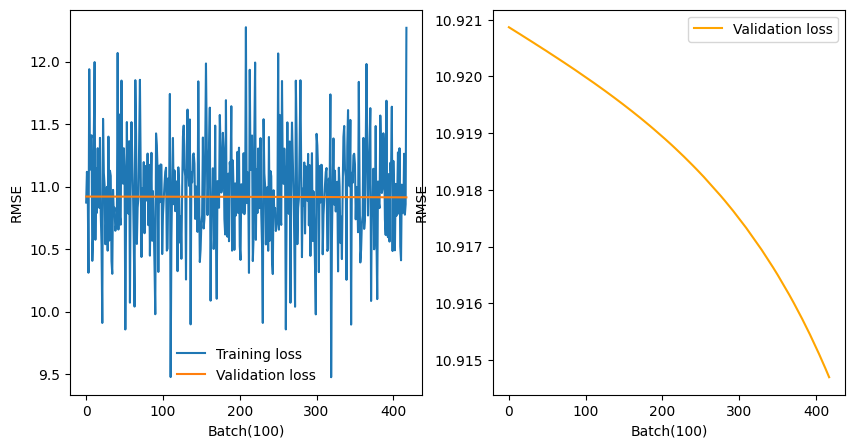

In [39]:
# plot training and validation loss (RMSE)
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
print("Best Step Count:", best_step_count+1, " ,Test Loss(RMSE):", test_loss ,",Valid Loss(RMSE):", best_valid_loss)
# plot in two pictures
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel("Batch(100)")
plt.ylabel("RMSE")
plt.subplot(1, 2, 2)
plt.plot(valid_losses, label='Validation loss' , color = 'orange')
plt.legend(frameon=False)
plt.xlabel("Batch(100)")
plt.ylabel("RMSE")
plt.legend()

We can see that the training loss varies a lot, however the validation loss kept dropping.

The reason why it oscilates that much might be the learning rate is too big, causing the performance to be unstable.

Since the validation loss kept improve, it was training by the whole 100 epoches.

# Q3
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。


Since I already made H as a parameter of `training_with_H()` we can simply call that function and get the parameters we needed.

In this case, it's `test_loss`, which is obtained by the best model, computed by `x_train`


In [22]:
# test with H = 90, 180

testrmsefor4590180 = [test_loss]

for h in [90, 180]:
    train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_H(h)
    testrmsefor4590180.append(test_loss)

df = pd.DataFrame(testrmsefor4590180, index = [45, 90, 180], columns = ['Test RMSE'])
df
#41 min

,Test RMSE
45,10.844928
90,10.829714
180,10.830807


We can see H = 90 performs the best, secondly 180, lastly 45.

We can conclude that too much or too little of hidden nodes aren't good.

There will be a particular value achieve the best(lowest) RMSE.

# Q4 
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?



There's another parameter we need to take into consideration, which is weight decay, we then adjust our `training_with_H()` function

Add another parameter called `weight_decay`, then start training.

In [25]:
# 使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?
def training_withH_decay(H, weight_decay):
    # Training settings
    bestmodel = None
    batch_size = 1000
    epochs = 100
    lr = 0.00001
    seed = 1
    log_interval = 100
    torch.manual_seed(seed)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_subtrain), torch.from_numpy(Y_subtrain)),
        batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), shuffle=False)
    model = Net(H)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    bestrun_train_loss = np.inf
    best_step_count = 0
    batch_run = 0
    for epoch in range(1, epochs + 1):
        bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, ifstop = train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel)
        if ifstop:
            break
    model = bestmodel
    test_loss = test(model, test_loader)
    return train_losses, valid_losses, test_loss, best_step_count, best_valid_loss

Hs = [45, 90, 180]
weight_decays = [0.1, 0.2, 0.4]
result = []

for H in Hs:
    tmp = []
    for weight_decay in weight_decays:
        train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_withH_decay(H, weight_decay)
        tmp.append(test_loss)
    result.append(tmp)

# draw table
import pandas as pd
df = pd.DataFrame(result, columns=weight_decays, index=Hs)
df

# 3hr

,0.1,0.2,0.4
45,10.846783,10.848133,10.849872
90,10.836697,10.841452,10.846991
180,10.837572,10.842083,10.847240


We can see that when weight_decay = 0.1, H = 90 yields the lowest RMSE.

When weight_decay = 0.1, H = 90 also yields the lowest RMSE.

When weight_decay = 0.4, H = 90 also yields the lowest RMSE.

We can obviously see that H = 90 is the best H.


# Q5
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In this problem, we add dropout layer after relu function of every layer, we modify our `Net`.

Another difference is the optimizer, we use Adam instead, hence we set `optimizer = optim.Adam(model.parameters(), lr=lr)`.

Moreover, lr = 0.001 in this case, no weight decay and momentum.

We do mostly the same thing as Q2, with the modifies mention above.

In [26]:
# 建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader: 
            data = data.to()
            target = target.to()
            output = model(data)
            output = output.view(-1)
            test_loss += F.mse_loss(output, target, reduction='sum').item() 
    test_loss /= len(test_loader.dataset)
    test_loss = sqrt(test_loss)
    # print('(RMSE): {:.4f}'.format(test_loss))
    return test_loss
class Net(nn.Module):
    def __init__(self, H):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc5 = nn.Linear(H, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc3(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc4(x)) 
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# 令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。
def train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_run += 1
        data = data.to()
        target = target.to() 
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze()
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_run % log_interval == 0:
            # print(f"Train Epoch: {epoch}, Batch_processed: {batch_run}, Train Loss(RMSE): {np.sqrt(loss.item()):.4f}", end = ", ")
            # save the loss, if validation loss is the lowest, save the model
            # print('Valid Loss', end='')
            valid_loss = test(model, valid_loader)
            train_losses.append(np.sqrt(loss.item()))
            valid_losses.append(valid_loss)
            if valid_loss < best_valid_loss:
                # print('New best')
                best_valid_loss = valid_loss
                bestrun_train_loss = loss.item()
                best_step_count = (epoch-1) * len(train_loader) + batch_idx
                bestmodel = model
            if (epoch-1) * len(train_loader)+batch_idx - best_step_count > 5000:
                return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, True
    return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, False

def training_with_H(H):
    # Training settings
    bestmodel = None
    batch_size = 1000
    epochs = 100
    lr = 0.001
    seed = 1
    log_interval = 100
    torch.manual_seed(seed)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_subtrain), torch.from_numpy(Y_subtrain)),
        batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), shuffle=False)
    model = Net(H)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    bestrun_train_loss = np.inf
    best_step_count = 0
    batch_run = 0
    for epoch in range(1, epochs + 1):
        bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, ifstop = train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel)
        if ifstop:
            break
    model = bestmodel
    test_loss = test(model, test_loader)
    return train_losses, valid_losses, test_loss, best_step_count, best_valid_loss

train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_H(90)
# 4min

Best Step Count: 3900  ,Test Loss(RMSE): 9.009191322510844 ,Valid Loss(RMSE): 8.532219648686432


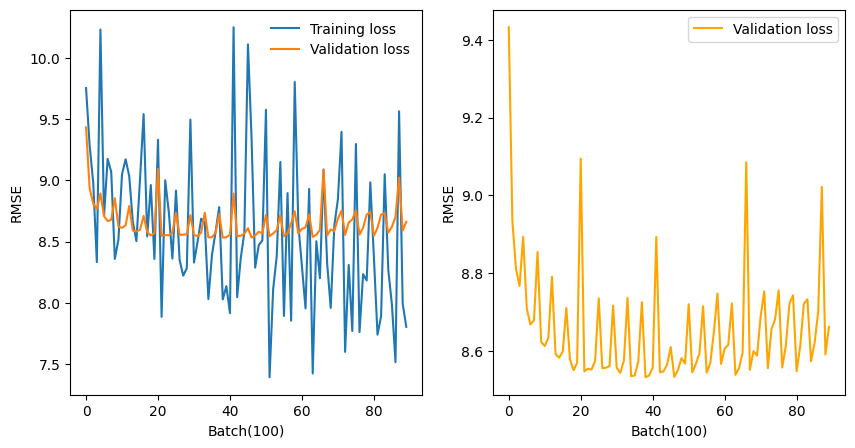

In [27]:
# plot training and validation loss (RMSE)
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
print("Best Step Count:", best_step_count+1, " ,Test Loss(RMSE):", test_loss ,",Valid Loss(RMSE):", best_valid_loss)
# plot in two pictures
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel("Batch(100)")
plt.ylabel("RMSE")
plt.subplot(1, 2, 2)
plt.plot(valid_losses, label='Validation loss' , color = 'orange')
plt.legend(frameon=False)
plt.xlabel("Batch(100)")
plt.ylabel("RMSE")
plt.legend()

The training loss varies a lot, which is the same as Q2.

The validation loss doesn't drop as smoothly as Q2, it's like a wave and has a pretty obvious pattern.

The reason for oscilation is usually because lr is too big.

The low point of oscilation kept dropping from batch 0~3900, then it started rising.

We can see the best batch is 3900.

# Q6 

使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

I wrote the training as a function which takes H as parameter, just simply iterate through the H list a put into df

In [28]:
H = [20, 45, 180, 360]
testrmseforH = []
for h in H:
    train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_H(h)
    testrmseforH.append(test_loss)

df = pd.DataFrame(testrmseforH, index = H, columns = ['Test RMSE'])
df
#32min

,Test RMSE
20,8.820495
45,8.839628
180,9.527078
360,9.669289


We can see H = 20 achieves the best RMSE, we can have the same conclusion as Q4, greater H doesn't leads to good test loss.

When the H is too big might leads to overfit.

In this case H greater than 20 lets the RMSE grows, we can check whether H less than 20 would have better performance, or the model is already overfitting.

# Q7

我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$

其中z為實數且$0 <=z <= 1$。
。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

We construct the custom loss through `custum_loss()` function according to the formula given.

Then set `loss` to be `cutsom_loss()`

Then, the rest is the same, except we need to save loss value to be RMSE rather than custom loss

Best Step Count: 3600  ,Test Loss(RMSE): 9.129308644314309 ,Valid Loss(RMSE): 8.553178035207225


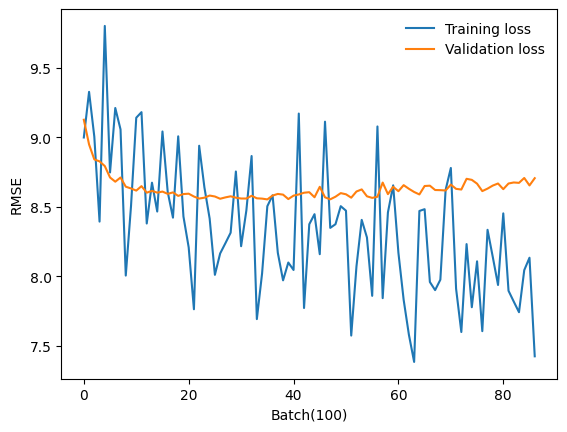

In [43]:
def custum_loss(output, target, z):
    return torch.sum(torch.abs(output - target)*(1-z) + torch.pow(output - target, 2)*z)

# 令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。
def train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, z):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_run += 1
        data = data.to()
        target = target.to() 
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze()
        loss_for_append = F.mse_loss(output, target)
        loss = custum_loss(output, target, z)
        loss.backward()
        optimizer.step()
        if batch_run % log_interval == 0:
            # print(f"Train Epoch: {epoch}, Batch_processed: {batch_run}, Train Loss(RMSE): {np.sqrt(loss.item()):.4f}", end = ", ")
            # save the loss, if validation loss is the lowest, save the model
            # print('Valid Loss', end='')
            valid_loss = test(model, valid_loader)
            train_losses.append(np.sqrt(loss_for_append.item()))
            valid_losses.append(valid_loss)
            if valid_loss < best_valid_loss:
                # print('New best')
                best_valid_loss = valid_loss
                bestrun_train_loss = loss.item()
                best_step_count = (epoch-1) * len(train_loader) + batch_idx
                bestmodel = model
            if (epoch-1) * len(train_loader)+batch_idx - best_step_count > 5000:
                return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, True
    return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, False

def training_with_Hz(H, z):
    # Training settings
    bestmodel = None
    batch_size = 1000
    test_batch_size = 1000
    epochs = 100
    lr = 0.001
    seed = 1
    log_interval = 100
    torch.manual_seed(seed)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_subtrain), torch.from_numpy(Y_subtrain)),
        batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), shuffle=False)
    model = Net(H)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    bestrun_train_loss = np.inf
    best_step_count = 0
    batch_run = 0
    for epoch in range(1, epochs + 1):
        bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, ifstop = train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, z)
        if ifstop:
            break
    model = bestmodel
    test_loss = test(model, test_loader)
    return train_losses, valid_losses, test_loss, best_step_count, best_valid_loss

train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_Hz(90, 0.5)

# plot training and validation loss (RMSE)
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

# plot
print("Best Step Count:", best_step_count+1, " ,Test Loss(RMSE):", test_loss ,",Valid Loss(RMSE):", best_valid_loss)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Batch(100)')
plt.ylabel('RMSE')
plt.show()
#5min

In [32]:
Z = [0.0, 0.1, 0.9, 1.0]
test_loss_for_z = []

for z in Z:
    train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_Hz(90, z)
    test_loss_for_z.append(test_loss)

df = pd.DataFrame(test_loss_for_z, index = Z, columns = ['Test RMSE'])
df
#19min

,Test RMSE
0.0,9.080224
0.1,9.086152
0.9,8.901983
1.0,9.220460


The validation loss didn't oscilates that much comparing to previous questions, the reason might be the new loss function.

The test RMSE kept dropping as we increases z, but when it reaches 1.0, the RMSE quickly rises.

Meaning mostly L2 loss function and a bit of L1 is the best loss function.

# Q8

考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

We adjust the `custom_loss()` function to take a parameter `z`.

Then set the return value to be the formula above.

The rest is the same.

In [41]:
def custum_loss(output, target, z):
    tminuso = target - output
    ominust = output - target
    # iterate over timunso, if value smaller than 0, set to 0
    tminuso[tminuso < 0] = 0
    ominust[ominust < 0] = 0
    return (1-z)*torch.sum(0.5*tminuso + 0.5*ominust) + z * torch.sum(torch.pow(target-output, 2))


def train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, z):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_run += 1
        data = data.to()
        target = target.to() 
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze()
        loss_for_append = F.mse_loss(output, target)
        loss = custum_loss(output, target, z)
        loss.backward()
        optimizer.step()
        if batch_run % log_interval == 0:
            # print(f"Train Epoch: {epoch}, Batch_processed: {batch_run}, Train Loss(RMSE): {np.sqrt(loss.item()):.4f}", end = ", ")
            # save the loss, if validation loss is the lowest, save the model
            # print('Valid Loss', end='')
            valid_loss = test(model, valid_loader)
            train_losses.append(np.sqrt(loss_for_append.item()))
            valid_losses.append(valid_loss)
            if valid_loss < best_valid_loss:
                # print('New best')
                best_valid_loss = valid_loss
                bestrun_train_loss = loss.item()
                best_step_count = (epoch-1) * len(train_loader) + batch_idx
                bestmodel = model
            if (epoch-1) * len(train_loader)+batch_idx - best_step_count > 5000:
                return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, True
    return bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, False

def training_with_Hz(H, z):
    # Training settings
    bestmodel = None
    batch_size = 1000
    test_batch_size = 1000
    epochs = 100
    lr = 0.001
    seed = 1
    log_interval = 100
    torch.manual_seed(seed)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_subtrain), torch.from_numpy(Y_subtrain)),
        batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), shuffle=False)
    model = Net(H)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    bestrun_train_loss = np.inf
    best_step_count = 0
    batch_run = 0
    for epoch in range(1, epochs + 1):
        bestrun_train_loss, best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, ifstop = train(model, train_loader, valid_loader, optimizer, epoch, log_interval, bestrun_train_loss , best_valid_loss, best_step_count, train_losses, valid_losses, batch_run, bestmodel, z)
        if ifstop:
            break
    model = bestmodel
    test_loss = test(model, test_loader)
    return train_losses, valid_losses, test_loss, best_step_count, best_valid_loss

Z = [0.1, 0.5, 0.9, 1.0]
test_loss_for_z = []

train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_Hz(90, 0)
# 6hr

Best Step Count: 4900  ,Test Loss(RMSE): 9.271698936049265 ,Valid Loss(RMSE): 8.815566980046887


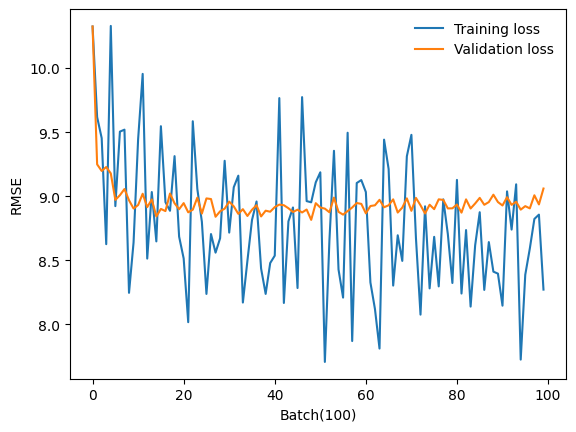

,Test RMSE
0.0,9.271699
0.1,9.163026
0.5,9.123703
0.9,9.047904
1.0,9.152792


In [42]:
print("Best Step Count:", best_step_count+1, " ,Test Loss(RMSE):", test_loss ,",Valid Loss(RMSE):", best_valid_loss)

# plot 
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Batch(100)')
plt.ylabel('RMSE')
plt.show()

test_loss_for_z.append(test_loss)

for z in Z:
    train_losses, valid_losses, test_loss, best_step_count, best_valid_loss = training_with_Hz(90, z)
    test_loss_for_z.append(test_loss)

Z = [0.0, 0.1, 0.5, 0.9, 1.0]

df = pd.DataFrame(test_loss_for_z, index = Z, columns = ['Test RMSE'])
df


We got best RMSE when z = 0.9, which is like the previos question, mostly L2 with a bit of qloss would give us the best loss function.